### Install

In [79]:
# install calmap
# ! pip install folium

### Import

In [14]:
# essential libraries
import random
from datetime import timedelta  

# storing and anaysis
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import calmap
import folium

# color pallette
cnf, dth, rec, act = '#393e46', '#ff2e63', '#21bf73', '#fe9801' 

# converter
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()   

# hide warnings
import warnings
warnings.filterwarnings('ignore')

# html embedding
from IPython.display import Javascript
from IPython.core.display import display
from IPython.core.display import HTML

# Dataset

In [80]:
# importing datasets
full_table = pd.read_csv('covid_19_clean_complete.csv', parse_dates=['Date'])
full_table.sample(10)

Province/State         Country/Region        Lat        Long  \
5249              Hubei                  China  30.975600  112.270700   
5205                NaN                Bahamas  25.034300  -77.396300   
7159                NaN  Saint Kitts and Nevis  17.357822  -62.782998   
8507         Guadeloupe                 France  16.250000  -61.583300   
10519               NaN             Kyrgyzstan  41.204400   74.766100   
14176               NaN                Ecuador  -1.831200  -78.183400   
361           St Martin                 France  18.070800  -63.050100   
8941              Anhui                  China  31.825700  117.226400   
10357               NaN               Zimbabwe -20.000000   30.000000   
2578   French Polynesia                 France -17.679700  149.406800   

            Date  Confirmed  Deaths  Recovered  
5249  2020-02-12      34874    1068       2686  
5205  2020-02-12          0       0          0  
7159  2020-02-19          0       0          0  
8507  2020-02-25          0       0          0  
10519 2020-03-04          0       0          0  
14176 2020-03-19        199       3          0  
361   2020-01-23          0       0          0  
8941  2020-02-27        989       6        792  
10357 2020-03-03          0       0          0  
2578  2020-02-01          0       0          0

In [30]:
# dataframe info
full_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16055 entries, 0 to 16054
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Province/State  4875 non-null   object        
 1   Country/Region  16055 non-null  object        
 2   Lat             16055 non-null  float64       
 3   Long            16055 non-null  float64       
 4   Date            16055 non-null  datetime64[ns]
 5   Confirmed       16055 non-null  int64         
 6   Deaths          16055 non-null  int64         
 7   Recovered       16055 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 1003.6+ KB


In [82]:
# checking for missing value
full_table.isna().sum()

Province/State    11180
Country/Region        0
Lat                   0
Long                  0
Date                  0
Confirmed             0
Deaths                0
Recovered             0
dtype: int64

# Preprocessing

### Cleaning Data

In [35]:
# cases 
cases = ['Confirmed', 'Deaths', 'Recovered', 'Active']

# Active Case = confirmed - deaths - recovered
full_table['Active'] = full_table['Confirmed'] - full_table['Deaths'] - full_table['Recovered']

# replacing Mainland china with just China
full_table['Country/Region'] = full_table['Country/Region'].replace('Mainland China', 'China')

# filling missing values 
full_table[['Province/State']] = full_table[['Province/State']].fillna('')
full_table[cases] = full_table[cases].fillna(0)

# fixing datatypes
full_table['Recovered'] = full_table['Recovered'].astype(int)

full_table.sample(6)

Province/State  Country/Region        Lat        Long       Date  \
6964                          Chile -35.675100  -71.543000 2020-02-19   
9719                  Cote d'Ivoire   7.540000   -5.547100 2020-03-01   
8140                    Timor-Leste  -8.874217  125.727539 2020-02-23   
1419                       Portugal  39.399900   -8.224500 2020-01-27   
6145        Bermuda  United Kingdom  32.307800  -64.750500 2020-02-15   
6649                      Venezuela   6.423800  -66.589700 2020-02-17   

      Confirmed  Deaths  Recovered  Active  
6964          0       0          0       0  
9719          0       0          0       0  
8140          0       0          0       0  
1419          0       0          0       0  
6145          0       0          0       0  
6649          0       0          0       0

### Derived Tables

In [36]:
# cases in the ships
ship = full_table[full_table['Province/State'].str.contains('Grand Princess')|full_table['Country/Region'].str.contains('Diamond Princess')]

# china and the row
china = full_table[full_table['Country/Region']=='China']
row = full_table[full_table['Country/Region']!='China']

# latest
full_latest = full_table[full_table['Date'] == max(full_table['Date'])].reset_index()
china_latest = full_latest[full_latest['Country/Region']=='China']
row_latest = full_latest[full_latest['Country/Region']!='China']

# latest condensed
full_latest_grouped = full_latest.groupby('Country/Region')['Confirmed', 'Deaths', 'Recovered', 'Active'].sum().reset_index()
china_latest_grouped = china_latest.groupby('Province/State')['Confirmed', 'Deaths', 'Recovered', 'Active'].sum().reset_index()
row_latest_grouped = row_latest.groupby('Country/Region')['Confirmed', 'Deaths', 'Recovered', 'Active'].sum().reset_index()

# Latest Data

### Latest Complete Data

In [37]:
temp = full_table.groupby(['Country/Region', 'Province/State'])['Confirmed', 'Deaths', 'Recovered', 'Active'].max()
# temp.style.background_gradient(cmap='Reds')

### Latest Condensed Data

In [38]:
temp = full_table.groupby('Date')['Confirmed', 'Deaths', 'Recovered', 'Active'].sum().reset_index()
temp = temp[temp['Date']==max(temp['Date'])].reset_index(drop=True)
temp['Global Moratality'] = temp['Deaths']/temp['Confirmed']
temp['Deaths per 100 Confirmed Cases'] = temp['Global Moratality']*100
temp.style.background_gradient(cmap='Pastel1')

In [39]:
from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)

In [40]:
tm = temp.melt(id_vars="Date", value_vars=['Active', 'Deaths', 'Recovered'])
fig = px.treemap(tm, path=["variable"], values="value", height=400, width=600,
                 color_discrete_sequence=[act, rec, dth])
fig.data[0].textinfo = 'label+text+value'
fig.show()

# Country wise Data

### In each country

In [41]:
temp_f = full_latest_grouped.sort_values(by='Confirmed', ascending=False)
temp_f = temp_f[['Country/Region', 'Confirmed', 'Active', 'Deaths', 'Recovered']]
temp_f = temp_f.reset_index(drop=True)

temp_f.style.background_gradient(cmap="Blues", subset=['Confirmed', 'Active'])\
            .background_gradient(cmap="Greens", subset=['Recovered'])\
            .background_gradient(cmap="Reds", subset=['Deaths'])

### Countries with Death reported

In [42]:
temp_flg = temp_f[temp_f['Deaths']>0][['Country/Region', 'Deaths']]
temp_flg['Deaths / 100 Cases'] = round((temp_f['Deaths']/temp_f['Confirmed'])*100, 2)
temp_flg.sort_values('Deaths', ascending=False).reset_index(drop=True).style.background_gradient(cmap='Reds')

# Maps

### Across the world

In [43]:
# World wide

m = folium.Map(location=[0, 0], tiles='cartodbpositron',
               min_zoom=1, max_zoom=4, zoom_start=1)

for i in range(0, len(full_latest)):
    folium.Circle(
        location=[full_latest.iloc[i]['Lat'], full_latest.iloc[i]['Long']],
        color='crimson', 
        tooltip =   '<li><bold>Country : '+str(full_latest.iloc[i]['Country/Region'])+
                    '<li><bold>Province : '+str(full_latest.iloc[i]['Province/State'])+
                    '<li><bold>Confirmed : '+str(full_latest.iloc[i]['Confirmed'])+
                    '<li><bold>Deaths : '+str(full_latest.iloc[i]['Deaths']),
        radius=int(full_latest.iloc[i]['Confirmed'])**1.1).add_to(m)
m

In [44]:
# Confirmed
fig = px.choropleth(full_latest_grouped, locations="Country/Region", 
                    locationmode='country names', color=np.log(full_latest_grouped["Confirmed"]), 
                    hover_name="Country/Region", hover_data=['Confirmed'],
                    color_continuous_scale="Sunsetdark", 
                    title='Countries with Confirmed Cases')
fig.update(layout_coloraxis_showscale=False)
fig.show()

In [45]:
# Deaths
temp = full_latest_grouped[full_latest_grouped['Deaths']>0]
fig = px.choropleth(temp, 
                    locations="Country/Region", locationmode='country names',
                    color=np.log(temp["Deaths"]), hover_name="Country/Region", 
                    color_continuous_scale="Peach", hover_data=['Deaths'],
                    title='Countries with Deaths Reported')
fig.update(layout_coloraxis_showscale=False)
fig.show()

In [46]:
formated_gdf = full_table.groupby(['Date', 'Country/Region'])['Confirmed', 'Deaths'].max()
formated_gdf = formated_gdf.reset_index()
formated_gdf['Date'] = pd.to_datetime(formated_gdf['Date'])
formated_gdf['Date'] = formated_gdf['Date'].dt.strftime('%m/%d/%Y')
formated_gdf['size'] = formated_gdf['Confirmed'].pow(0.3)

fig = px.scatter_geo(formated_gdf, locations="Country/Region", locationmode='country names', 
                     color="Confirmed", size='size', hover_name="Country/Region", 
                     range_color= [0, max(formated_gdf['Confirmed'])+2], animation_frame="Date", 
                     title='Spread over time')
fig.update(layout_coloraxis_showscale=False)
fig.show()

# Ships

In [47]:
# Latest cases from the ships
temp = ship[ship['Date']==max(ship['Date'])]
temp = temp[['Country/Region', 'Province/State', 'Confirmed', 'Deaths']].groupby(['Country/Region', 'Province/State']).sum().reset_index()
temp.style.background_gradient(cmap='Pastel1_r')

# Cases over the time

In [48]:
temp = full_table.groupby('Date')['Recovered', 'Deaths', 'Active'].sum().reset_index()
temp = temp.melt(id_vars="Date", value_vars=['Recovered', 'Deaths', 'Active'],
                 var_name='Case', value_name='Count')
temp.head()

fig = px.area(temp, x="Date", y="Count", color='Case', height=800,
             title='Cases over time', color_discrete_sequence = [rec, dth, act])
fig.update_layout(xaxis_rangeslider_visible=True)
fig.show()

In [49]:
# ------------------------------------------------------------------------------------------

temp = full_table.groupby('Date')['Confirmed', 'Deaths', 'Recovered'].sum().reset_index()
temp['No. of Deaths to 100 Confirmed Cases'] = round(temp['Deaths']/temp['Confirmed'], 3)*100
temp['No. of Recovered to 100 Confirmed Cases'] = round(temp['Recovered']/temp['Confirmed'], 3)*100

fig_1 = px.area(temp, x="Date", y="Confirmed", color_discrete_sequence = [act])
fig_2 = px.area(temp, x="Date", y="Deaths", color_discrete_sequence = [dth])
fig_3 = px.line(temp, x="Date", y="No. of Deaths to 100 Confirmed Cases",  color_discrete_sequence=['#333333'])
fig_4 = px.line(temp, x="Date", y="No. of Recovered to 100 Confirmed Cases",  color_discrete_sequence=['#0f4c75'])

# ------------------------------------------------

spread = full_table[full_table['Confirmed']!=0].groupby('Date')['Country/Region'].unique().apply(len)
spread = pd.DataFrame(spread).reset_index()

fig_5 = px.line(spread, x='Date', y='Country/Region',  color_discrete_sequence=[dth])

# -------------------------------------------------------------------------------------------

temp = full_table.groupby(['Country/Region', 'Date', ])['Confirmed', 'Deaths']
temp = temp.sum().diff().reset_index()

mask = temp['Country/Region'] != temp['Country/Region'].shift(1)

temp.loc[mask, 'Confirmed'] = np.nan
temp.loc[mask, 'Deaths'] = np.nan

temp = temp.groupby('Date')['Confirmed'].sum().reset_index()

fig_6 = px.bar(temp, x="Date", y="Confirmed", color_discrete_sequence=['#2a7886'])
fig_6.update_layout(xaxis_rangeslider_visible=True)

# ==========================================================================================

fig = make_subplots(rows=3, cols=2, shared_xaxes=False, vertical_spacing=0.08, horizontal_spacing=0.1,
                    subplot_titles=('Confirmed cases', 'Deaths reported', 
                                    'No. of deaths to 100 Confirmed', 'No. of recovered cases to 100 Confirmed', 
                                    'No. of new countries everyday', 'No. of new cases everyday'))

fig.add_trace(fig_1['data'][0], row=1, col=1)
fig.add_trace(fig_2['data'][0], row=1, col=2)
fig.add_trace(fig_3['data'][0], row=2, col=1)
fig.add_trace(fig_4['data'][0], row=2, col=2)
fig.add_trace(fig_5['data'][0], row=3, col=1)
fig.add_trace(fig_6['data'][0], row=3, col=2)

fig.update_layout(height=1200)

# Top 20 Countries

In [65]:
flg = full_latest_grouped.copy('deept')
# flg.head()

# mortality rate

flg['Mortality Rate'] = round((flg['Deaths']/flg['Confirmed'])*100, 2)
temp_m = flg[flg['Confirmed']>100]
temp_m = temp_m.sort_values('Mortality Rate', ascending=False)

# load population dataset
pop_clean_data = pd.read_csv("population_total_long.csv")
pop = pop_clean_data[pop_clean_data['Year']==max(pop_clean_data['Year'])]
# select only the latest data
pop = pop.loc[:, ['Country Name', 'Count']]

# substitute for missing values
cols = ['French Guiana', 'Martinique', 'Palestine' , 'Republic of Ireland', 'Saint Barthelemy', 'Taiwan', 'Vatican City']
pops = [290691, 376480, 4750000, 4920455, 7122, 23476640, 1000]
for c, p in zip(cols, pops):
    pop.loc[pop['Country Name']== c, 'Count'] = p

# replace country names 
name = {
    'Egypt, Arab Rep.': 'Egypt',
    'Hong Kong SAR, China': 'Hong Kong',
    'Iran, Islamic Rep.': 'Iran (Islamic Republic of)',
    'Macao SAR, China': 'Macau',
    'Hong Kong SAR': 'Hong Kong',
    'Russian Federation': 'Russia',
    'Slovak Republic': 'Slovakia',
    'Korea, Rep.': 'Republic of Korea',
    'United Kingdom': 'UK',
    'United States': 'US' }
pop.loc[:, 'Country Name'] = pop.loc[: 'Country Name'].replace(name)

# merge dataframes
temp = pd.merge(full_latest_grouped, pop, how='left', right_on='Country Name', left_on='Country/Region')
# print(temp[temp['Country Name'].isna()])

temp = temp[['Country/Region', 'Confirmed', 'Deaths', 'Recovered', 'Active', 'Count']]
temp.columns = ['Country/Region', 'Confirmed', 'Deaths', 'Recovered', 'Active', 'Population']
    
# calculate Confirmed/Population
temp['Confirmed Per Million People'] = round(temp['Confirmed']/temp['Population']*1000000, 2)

# countries with population greater that 1 million only
temp_p = temp[temp['Population']>1000000].sort_values('Confirmed Per Million People', ascending=False).reset_index(drop=True)
# temp_p.head()

In [66]:
# Confirmed ==================================================================================================

fig_c = px.bar(flg.sort_values('Confirmed').tail(20), x="Confirmed", y="Country/Region", text='Confirmed', orientation='h')
fig_c.update_traces(marker_color='#000839', opacity=0.8, textposition='auto')
fig_c.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')

# Deaths ===================================================================================================

fig_d = px.bar(flg.sort_values('Deaths').tail(20), x="Deaths", y="Country/Region",  text='Deaths', orientation='h')
fig_d.update_traces(marker_color='#ff1e56', opacity=0.8, textposition='auto')
fig_d.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')

# Recovered =================================================================================================

fig_r = px.bar(flg.sort_values('Recovered').tail(20), x="Recovered", y="Country/Region", text='Recovered', orientation='h')
fig_r.update_traces(marker_color=rec, opacity=0.8, textposition='auto')
fig_r.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')

# Active ====================================================================================================

fig_a = px.bar(flg.sort_values('Active').tail(20), x="Active", y="Country/Region", text='Active', orientation='h')
fig_a.update_traces(marker_color=act, opacity=0.8, textposition='auto')
fig_a.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')

# Moratality ================================================================================================

fig_m = px.bar(temp_m.sort_values('Mortality Rate').tail(20), x="Mortality Rate", y="Country/Region", text='Mortality Rate', orientation='h')
fig_m.update_traces(marker_color='#00bdaa', opacity=0.8, textposition='auto')
fig_m.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')

# Per Million People =================================================================================================

fig_p = px.bar(temp_p.sort_values('Confirmed Per Million People').tail(20), x='Confirmed Per Million People', y='Country/Region', orientation='h', text='Confirmed Per Million People')
fig_p.update_traces(marker_color='#2c003e', opacity=0.8, textposition='auto')
fig_p.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')

# ==========================================================================================================

fig = make_subplots(rows=3, cols=2, shared_xaxes=False, vertical_spacing=0.08, horizontal_spacing=0.1,
                    subplot_titles=("Confirmed", "Deaths", "Recovered", "Active", "Moratlity rate", "Confirmed cases per Million People"))
fig.add_trace(fig_c['data'][0], row=1, col=1)
fig.add_trace(fig_d['data'][0], row=1, col=2)
fig.add_trace(fig_r['data'][0], row=2, col=1)
fig.add_trace(fig_a['data'][0], row=2, col=2)
fig.add_trace(fig_m['data'][0], row=3, col=1)
fig.add_trace(fig_p['data'][0], row=3, col=2)
fig.update_layout(height=1200, title_text="Top 20")

In [68]:
fig = px.scatter(full_latest_grouped.sort_values('Deaths', ascending=False).iloc[:15, :], 
                 x='Confirmed', y='Deaths', color='Country/Region', size='Confirmed', height=800,
                 text='Country/Region', log_x=True, log_y=True, title='Deaths vs Confirmed')
fig.update_traces(textposition='top center')
fig.update_layout(xaxis_rangeslider_visible=True)
fig.show()

# Date vs

In [69]:
temp = full_table.groupby(['Country/Region', 'Date'])['Confirmed', 'Deaths'].sum()
temp = temp.reset_index()

fig = px.bar(temp, x="Date", y="Confirmed", color='Country/Region', orientation='v', height=600,
             title='Confirmed', color_discrete_sequence = px.colors.cyclical.mygbm)
fig.update_layout(xaxis_rangeslider_visible=True)
fig.show()

# =========================================

fig = px.bar(temp, x="Date", y="Deaths", color='Country/Region', orientation='v', height=600,
             title='Deaths', color_discrete_sequence = px.colors.cyclical.mygbm)
fig.update_layout(xaxis_rangeslider_visible=True)
fig.show()

# =========================================

temp = full_table.groupby(['Country/Region', 'Date', ])['Confirmed', 'Deaths']
temp = temp.sum().diff().reset_index()

mask = temp['Country/Region'] != temp['Country/Region'].shift(1)

temp.loc[mask, 'Confirmed'] = np.nan
temp.loc[mask, 'Deaths'] = np.nan

fig = px.bar(temp, x="Date", y="Confirmed", color='Country/Region',title='New cases')
fig.update_layout(xaxis_rangeslider_visible=True)
fig.show()

In [70]:
temp = full_table.groupby(['Date', 'Country/Region'])['Confirmed'].sum().reset_index().sort_values('Confirmed', ascending=False)

fig = px.line(temp, x="Date", y="Confirmed", color='Country/Region', title='Cases Spread', height=600)
fig.update_layout(xaxis_rangeslider_visible=True)
fig.show()

#================================

temp = full_table.groupby(['Date', 'Country/Region'])['Deaths'].sum().reset_index().sort_values('Deaths', ascending=False)

fig = px.line(temp, x="Date", y="Deaths", color='Country/Region', title='Deaths', height=600)
fig.update_layout(xaxis_rangeslider_visible=True)
fig.show()

In [71]:
# temp = full_table.groupby(['Date', 'Country/Region'])['Confirmed'].sum().reset_index()
# temp = temp.sort_values('Confirmed').reset_index(drop=True).head(20)
# # temp['Date'] = temp['Date'].dt.strftime('%Y-%m-%d')
# temp = temp.sort_values(by='Date')
# temp['Date'] = temp['Date'].apply(lambda x: x.date()).apply(str)
# temp.head()

# fig = px.bar(temp, y='Country/Region', x='Confirmed', color='Country/Region', orientation='h',  
#              title='Over time', animation_frame='Date', height=1000, log_x=True)
# # fig.update_traces(textposition='outside')
# # fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
# # fig.update_layout(yaxis={'categoryorder':'array', 
# #                          'categoryarray':['Hubei','Other Chinese Provinces','Rest of the World']})
# fig.show()

In [72]:
gt_100 = full_latest_grouped[full_latest_grouped['Confirmed']>100]['Country/Region'].unique()
temp = full_table[full_table['Country/Region'].isin(gt_100)]
temp = temp.groupby(['Country/Region', 'Date'])['Confirmed'].sum().reset_index()
temp = temp[temp['Confirmed']>100]
# print(temp.head())

min_date = temp.groupby('Country/Region')['Date'].min().reset_index()
min_date.columns = ['Country/Region', 'Min Date']
# print(min_date.head())

from_100th_case = pd.merge(temp, min_date, on='Country/Region')
from_100th_case['N days'] = (from_100th_case['Date'] - from_100th_case['Min Date']).dt.days
# print(from_100th_case.head())

fig = px.line(from_100th_case, x='N days', y='Confirmed', color='Country/Region', title='N days from 100 case', height=800)
fig.update_layout(xaxis_rangeslider_visible=True)
fig.show()

# ===========================================================================

gt_1000 = full_latest_grouped[full_latest_grouped['Confirmed']>1000]['Country/Region'].unique()
temp = full_table[full_table['Country/Region'].isin(gt_1000)]
temp = temp.groupby(['Country/Region', 'Date'])['Confirmed'].sum().reset_index()
temp = temp[temp['Confirmed']>1000]
# print(temp.head())

min_date = temp.groupby('Country/Region')['Date'].min().reset_index()
min_date.columns = ['Country/Region', 'Min Date']
# print(min_date.head())

from_1000th_case = pd.merge(temp, min_date, on='Country/Region')
from_1000th_case['N days'] = (from_1000th_case['Date'] - from_1000th_case['Min Date']).dt.days
# print(from_1000th_case.head())

fig = px.line(from_1000th_case, x='N days', y='Confirmed', color='Country/Region', title='N days from 1000 case', height=800)
fig.update_layout(xaxis_rangeslider_visible=True)
fig.show()

# ===========================================================================

gt_10000 = full_latest_grouped[full_latest_grouped['Confirmed']>10000]['Country/Region'].unique()
temp = full_table[full_table['Country/Region'].isin(gt_10000)]
temp = temp.groupby(['Country/Region', 'Date'])['Confirmed'].sum().reset_index()
temp = temp[temp['Confirmed']>10000]
# print(temp.head())

min_date = temp.groupby('Country/Region')['Date'].min().reset_index()
min_date.columns = ['Country/Region', 'Min Date']
# print(min_date.head())

from_10000th_case = pd.merge(temp, min_date, on='Country/Region')
from_10000th_case['N days'] = (from_10000th_case['Date'] - from_10000th_case['Min Date']).dt.days
# print(from_10000th_case.head())

fig = px.line(from_10000th_case, x='N days', y='Confirmed', color='Country/Region', title='N days from 10000 case', height=800)
fig.update_layout(xaxis_rangeslider_visible=True)
fig.show()

# Composition of Cases

In [73]:
fig = px.treemap(full_latest.sort_values(by='Confirmed', ascending=False).reset_index(drop=True), 
                 path=["Country/Region", "Province/State"], values="Confirmed", height=700,
                 title='Number of Confirmed Cases',
                 color_discrete_sequence = px.colors.qualitative.Prism)
fig.data[0].textinfo = 'label+text+value'
fig.show()

fig = px.sunburst(full_latest.sort_values(by='Deaths', ascending=False).reset_index(drop=True), 
                 path=["Country/Region", "Province/State"], values="Deaths", height=700,
                 title='Number of Deaths reported',
                 color_discrete_sequence = px.colors.qualitative.Prism)
fig.data[0].textinfo = 'label+text+value'
fig.show()

# Epidemic Span

Note : In the graph, last day is shown as one day after the last time a new confirmed cases reported in the Country / Region

In [55]:
# first date
# ==========
first_date = full_table[full_table['Confirmed']>0]
first_date = first_date.groupby('Country/Region')['Date'].agg(['min']).reset_index()
# first_date.head()

# last date
# =========
last_date = full_table.groupby(['Country/Region', 'Date', ])['Confirmed', 'Deaths', 'Recovered']
last_date = last_date.sum().diff().reset_index()

mask = last_date['Country/Region'] != last_date['Country/Region'].shift(1)
last_date.loc[mask, 'Confirmed'] = np.nan
last_date.loc[mask, 'Deaths'] = np.nan
last_date.loc[mask, 'Recovered'] = np.nan

last_date = last_date[last_date['Confirmed']>0]
last_date = last_date.groupby('Country/Region')['Date'].agg(['max']).reset_index()
# last_date.head()

# first_last
# ==========
first_last = pd.concat([first_date, last_date[['max']]], axis=1)

# added 1 more day, which will show the next day as the day on which last case appeared
first_last['max'] = first_last['max'] + timedelta(days=1)

# no. of days
first_last['Days'] = first_last['max'] - first_last['min']

# task column as country
first_last['Task'] = first_last['Country/Region']

# rename columns
first_last.columns = ['Country/Region', 'Start', 'Finish', 'Days', 'Task']

# sort by no. of days
first_last = first_last.sort_values('Days')
# first_last.head()

# visualization
# =============

# produce random colors
clr = ["#"+''.join([random.choice('0123456789ABC') for j in range(6)]) for i in range(len(first_last))]

# plot
fig = ff.create_gantt(first_last, index_col='Country/Region', colors=clr, show_colorbar=False, 
                      bar_width=0.2, showgrid_x=True, showgrid_y=True, height=2500)
fig.show()

https://app.flourish.studio/visualisation/1571387/edit



In [56]:
HTML('''<div class="flourish-embed flourish-bar-chart-race" data-src="visualisation/1571387"><script src="https://public.flourish.studio/resources/embed.js"></script></div>''')

# Country Wise

### Confirmed cases (countries with > 1000 cases)

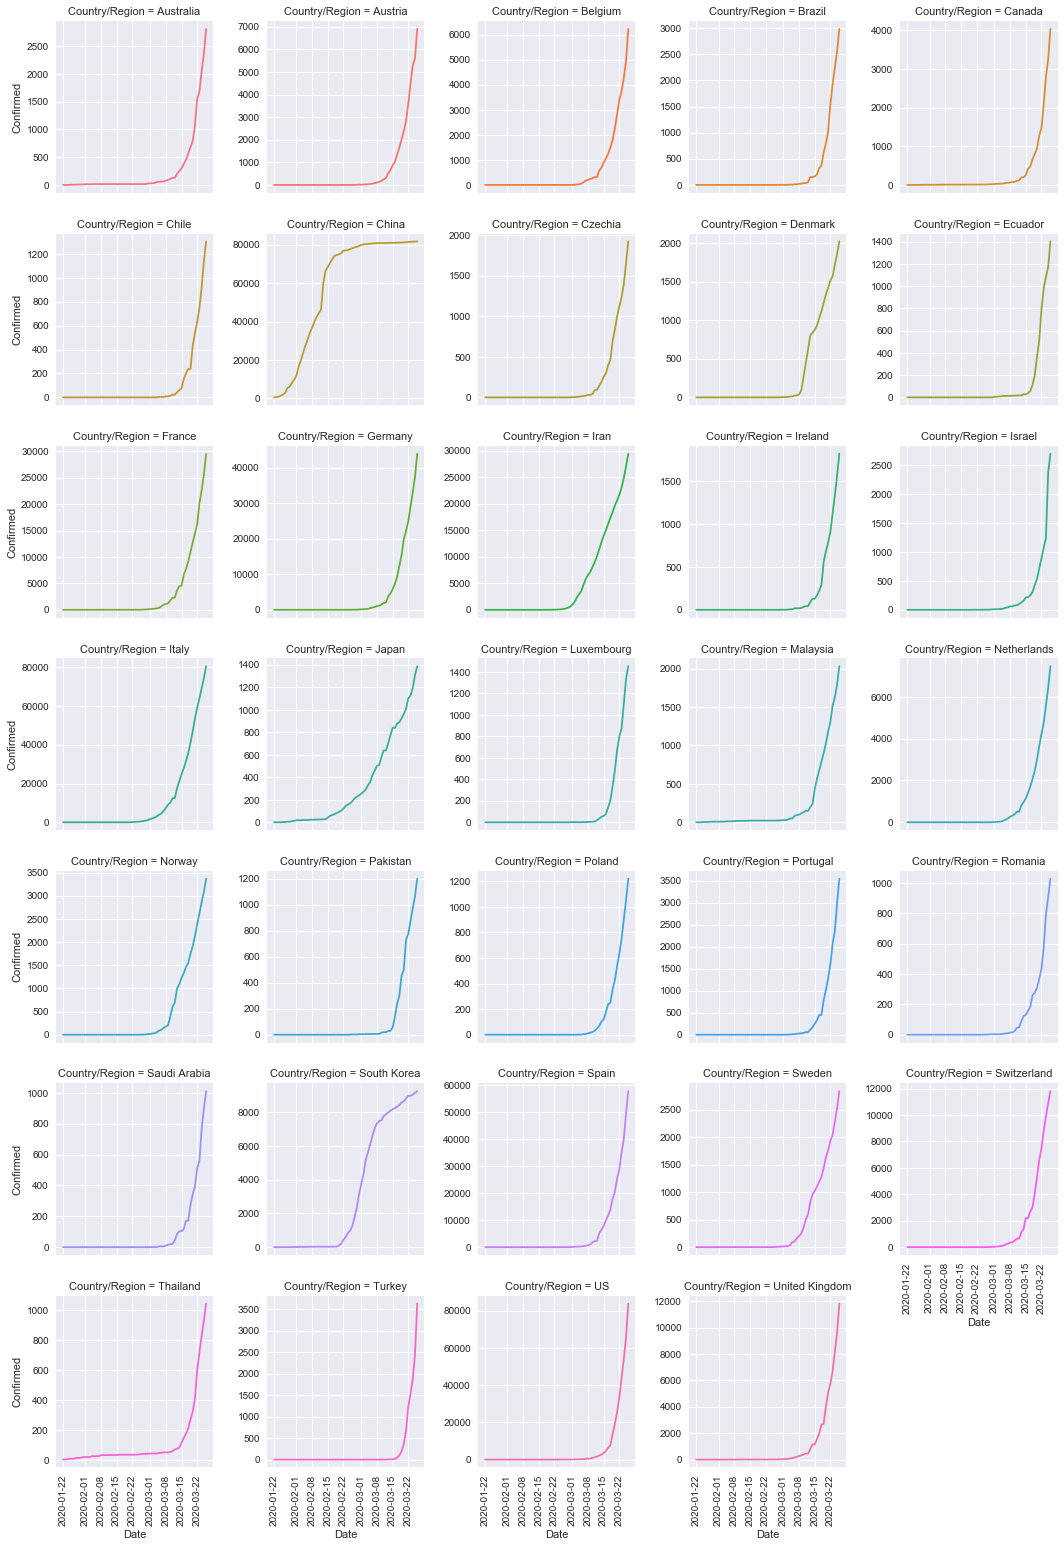

In [58]:
temp = full_table.groupby(['Date', 'Country/Region'])['Confirmed'].sum()
temp = temp.reset_index().sort_values(by=['Date', 'Country/Region'])
temp = temp[temp['Country/Region'].isin(gt_1000)]

plt.style.use('seaborn')
g = sns.FacetGrid(temp, col="Country/Region", hue="Country/Region", sharey=False, col_wrap=5)
g = g.map(plt.plot, "Date", "Confirmed")
g.set_xticklabels(rotation=90)
plt.show()

### New cases (countries with > 1000 cases)

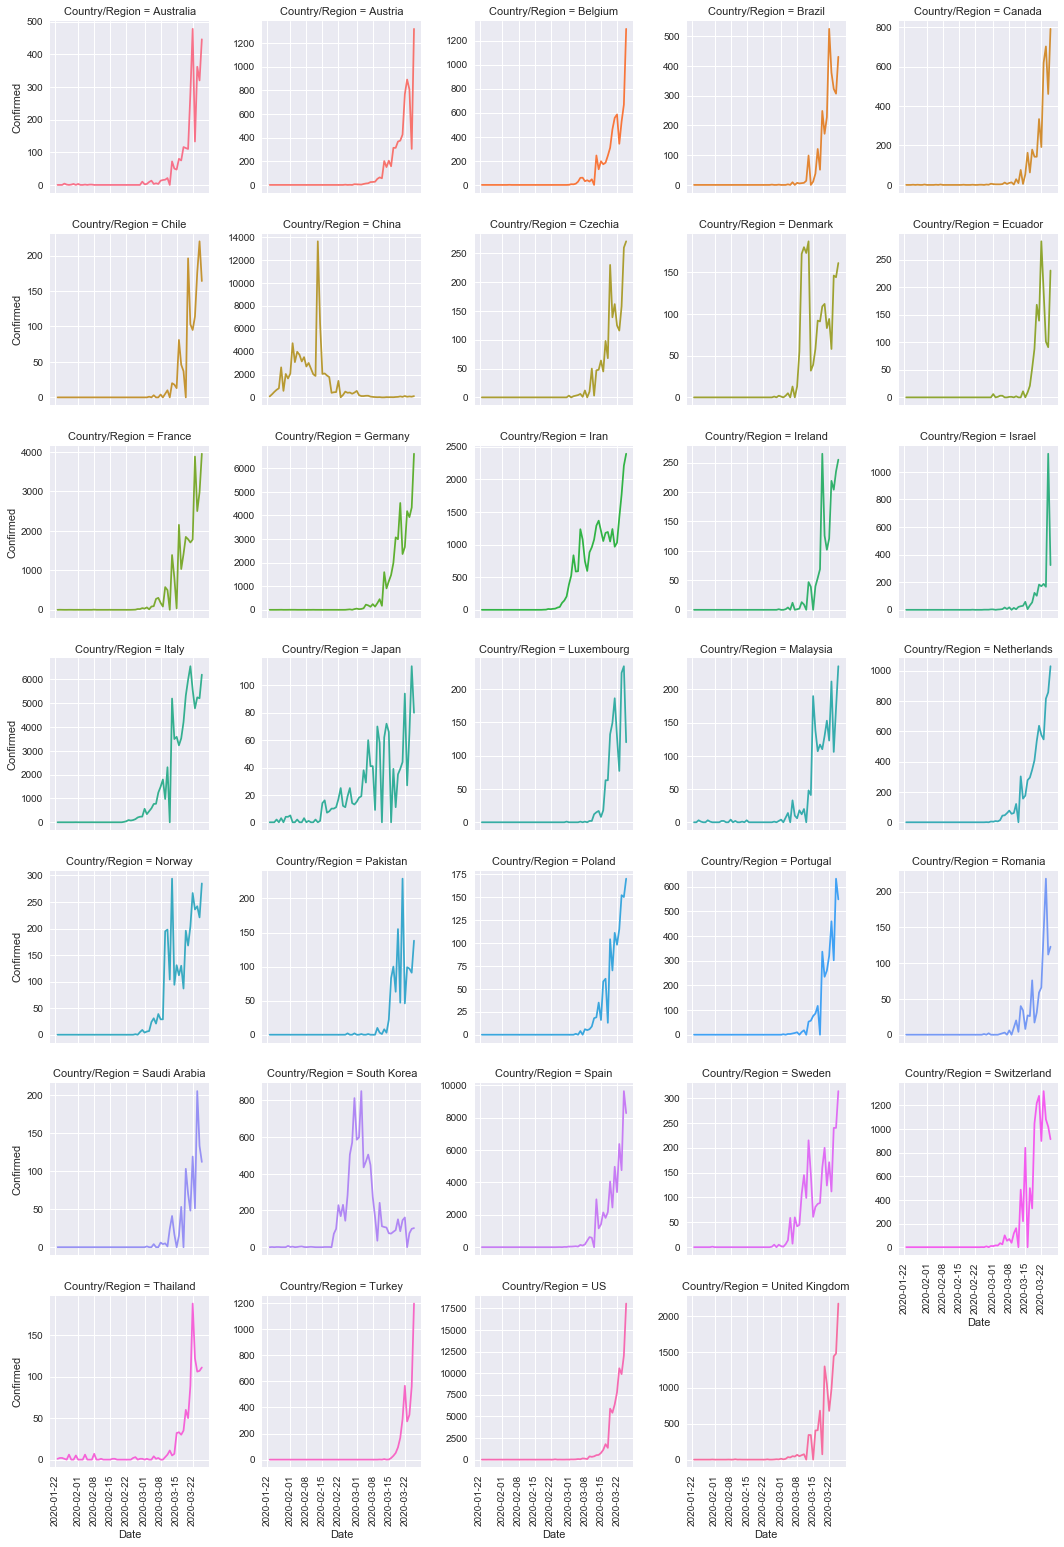

In [59]:
temp = full_table.groupby(['Country/Region', 'Date', ])['Confirmed', 'Deaths', 'Recovered']
temp = temp.sum().diff().reset_index()
temp = temp[temp['Country/Region'].isin(gt_1000)]

mask = temp['Country/Region'] != temp['Country/Region'].shift(1)

temp.loc[mask, 'Confirmed'] = np.nan
temp.loc[mask, 'Deaths'] = np.nan
temp.loc[mask, 'Recovered'] = np.nan

plt.style.use('seaborn')
g = sns.FacetGrid(temp, col="Country/Region", hue="Country/Region",  sharey=False, col_wrap=5)
g = g.map(sns.lineplot, "Date", "Confirmed")
g.set_xticklabels(rotation=90)
plt.show()

# Calander map

### Number of new cases every day

In [76]:
temp = full_table.groupby('Date')['Confirmed'].sum()
temp = temp.diff()

plt.figure(figsize=(20, 5))
# ax = calmap.yearplot(temp, fillcolor='white', cmap='Reds', linewidth=0.5)

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

In [77]:
temp

Date
2020-01-22        NaN
2020-01-23       99.0
2020-01-24      287.0
2020-01-25      493.0
2020-01-26      684.0
               ...   
2020-03-22    32557.0
2020-03-23    41282.0
2020-03-24    39810.0
2020-03-25    49608.0
2020-03-26    61938.0
Name: Confirmed, Length: 65, dtype: float64

### Number of new countries every day

AttributeError: 'DataFrame' object has no attribute 'ix'

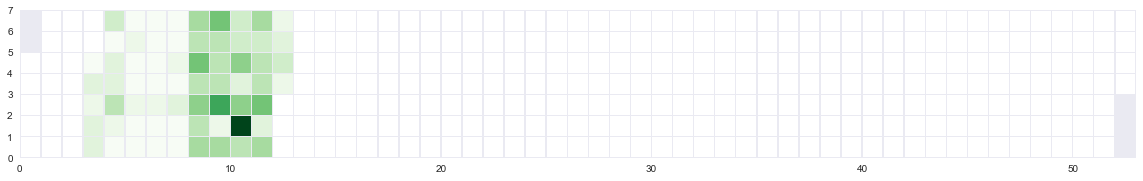

In [78]:
spread = full_table[full_table['Confirmed']!=0].groupby('Date')
spread = spread['Country/Region'].unique().apply(len).diff()

plt.figure(figsize=(20, 5))
ax = calmap.yearplot(spread, fillcolor='white', cmap='Greens', linewidth=0.5)

# Comparison with similar epidemics

https://www.kaggle.com/imdevskp/covid19-vs-sars-vs-mers-vs-ebola-vs-h1n1



In [62]:
epidemics = pd.DataFrame({
    'epidemic' : ['COVID-19', 'SARS', 'EBOLA', 'MERS', 'H1N1'],
    'start_year' : [2019, 2003, 2014, 2012, 2009],
    'end_year' : [2020, 2004, 2016, 2017, 2010],
    'confirmed' : [full_latest['Confirmed'].sum(), 8096, 28646, 2494, 6724149],
    'deaths' : [full_latest['Deaths'].sum(), 774, 11323, 858, 19654]
})

epidemics['mortality'] = round((epidemics['deaths']/epidemics['confirmed'])*100, 2)

epidemics.head()

epidemic  start_year  end_year  confirmed  deaths  mortality
0  COVID-19        2019      2020     529591   23970       4.53
1      SARS        2003      2004       8096     774       9.56
2     EBOLA        2014      2016      28646   11323      39.53
3      MERS        2012      2017       2494     858      34.40
4      H1N1        2009      2010    6724149   19654       0.29

In [63]:
temp = epidemics.melt(id_vars='epidemic', value_vars=['confirmed', 'deaths', 'mortality'],
                      var_name='Case', value_name='Value')

fig = px.bar(temp, x="epidemic", y="Value", color='epidemic', text='Value', facet_col="Case",
             color_discrete_sequence = px.colors.qualitative.Bold)
fig.update_traces(textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.update_yaxes(showticklabels=False)
fig.layout.yaxis2.update(matches=None)
fig.layout.yaxis3.update(matches=None)
fig.show()

# Analysis on similar epidemics

https://www.kaggle.com/imdevskp/mers-outbreak-analysis  
https://www.kaggle.com/imdevskp/sars-2003-outbreak-analysis  
https://www.kaggle.com/imdevskp/western-africa-ebola-outbreak-analysis
